In [1]:
import pandas as pd
import re

from neo4j import GraphDatabase

import os
from dotenv import load_dotenv

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
load_dotenv()

True

In [2]:
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

In [3]:
class Neo4jHandler:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_player_classifications_as_df(self):
        query = """
        MATCH (p:Player)-[r:HAS_CLASSIFICATION]->(c:Classification)
        RETURN p.Actor AS player_id, c.type AS classification
        """
        with self.driver.session() as session:
            result = session.run(query)
            data = [{"player_id": record["player_id"], "classification": record["classification"]} for record in result]
            
            # Parse classification, confidence, and reasoning from the LLM
            parsed_data = []
            for row in data:
                result = row["classification"]  # Assuming the LLM response is stored here, change if it is stored in p properties
                classification_match = re.search(r'Classification[:\*]\s*(\w+)', result, re.IGNORECASE)
                classification = classification_match.group(1) if classification_match else None
                
                # Extract Confidence
                confidence_match = re.search(r'Confidence[:\*]\s*(\d+)', result, re.IGNORECASE)
                confidence = int(confidence_match.group(1)) if confidence_match else None
                
                # Extract Reasoning
                reasoning_match = re.search(r'Reasoning[:\*]\s*(.*)', result, re.IGNORECASE)
                reasoning = reasoning_match.group(1).strip() if reasoning_match else None

                parsed_data.append({"Actor": row['player_id'],"Classification": classification, "Confidence": confidence, "Reasoning": reasoning})
            return pd.DataFrame(parsed_data)



In [4]:

handler = Neo4jHandler(uri, username, password)
try:
    df= handler.get_player_classifications_as_df()
finally:
    handler.close()

In [5]:
df

,Actor,Classification,Confidence,Reasoning
0,400211,Human,90.0,The player's behavior is mostly consistent wit...
1,427661,Bot,95.0,** The analysis from multiple agents strongly ...
2,453598,None,NaN,** The high score in the Player Action Analysi...
3,453460,Bot,92.0,The Social Diversity Analysis and Player Actio...
4,383722,Bot,95.0,The combination of high anomaly scores from mu...
5,387473,None,NaN,** The player exhibits a combination of behavi...
6,412331,Human,70.0,The player's high social diversity score and l...
7,370220,Human,80.0,The player's behavior shows some minor irregul...
8,416244,None,NaN,"** Although the Anomaly Detection score is 40,..."
9,423563,Bot,95.0,"** The player's behavior, as analyzed through ..."


In [6]:
df.dropna(inplace=True)
df

,Actor,Classification,Confidence,Reasoning
0,400211,Human,90.0,The player's behavior is mostly consistent wit...
1,427661,Bot,95.0,** The analysis from multiple agents strongly ...
3,453460,Bot,92.0,The Social Diversity Analysis and Player Actio...
4,383722,Bot,95.0,The combination of high anomaly scores from mu...
6,412331,Human,70.0,The player's high social diversity score and l...
7,370220,Human,80.0,The player's behavior shows some minor irregul...
9,423563,Bot,95.0,"** The player's behavior, as analyzed through ..."
10,24824,Human,80.0,The player's behavior is deemed legitimate bas...
12,464033,Human,80.0,"The player exhibits some anomalous behavior, s..."
13,432507,Bot,98.0,The player's behavior is highly indicative of ...


In [8]:
df.drop_duplicates(subset=['Actor'], inplace=True)
df.shape

(27, 4)

In [9]:
social_data = pd.read_csv('../data/sample/sample_social_data.csv')

social_data = social_data[social_data['Actor'].isin(df['Actor'])]
social_data.drop(columns=['A_Acc', 'Social_diversity'], inplace=True)
eval_df = social_data.merge(df, on='Actor', how='left')
eval_df.dropna(inplace=True)
eval_df

,Actor,Type,Classification,Confidence,Reasoning
0,24824,Human,Human,80.0,The player's behavior is deemed legitimate bas...
1,68875,Human,Human,70.0,The player's anomaly detection score (40) and ...
2,283113,Bot,Bot,60.0,** The player's behavior exhibits several char...
3,325991,Bot,Bot,90.0,The Player Action Analysis indicates a high bo...
4,370220,Human,Human,80.0,The player's behavior shows some minor irregul...
5,383722,Bot,Bot,95.0,The combination of high anomaly scores from mu...
6,389398,Human,Human,90.0,The player's behavior is consistent across all...
7,395176,Human,Human,95.0,The player's behavior is consistently indicati...
8,396698,Bot,Bot,90.0,"** The high score in Player Action Analysis, i..."
9,400211,Human,Human,90.0,The player's behavior is mostly consistent wit...


In [10]:
eval_df['Type'] = eval_df['Type'].apply(lambda x: 1 if x == 'Bot' else 0)
eval_df['Classification'] = eval_df['Classification'].apply(lambda x: 1 if x == 'Bot' else 0)

In [12]:
y_true = eval_df['Type']
y_pred = eval_df['Classification']

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.9630
Precision: 1.0000
Recall: 0.9091
F1 Score: 0.9524
Confusion Matrix:
 [[16  0]
 [ 1 10]]


<Axes: >

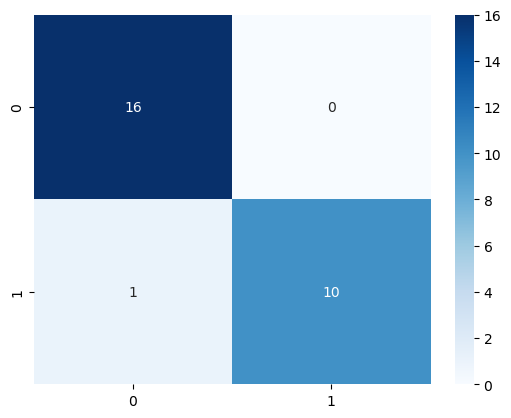

In [40]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')

In [13]:
eval_df.to_csv('./llm_evaluation_output/eval_classification_8-4-25_llama-70b.csv')

In [14]:
from ragas import evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ragas.llms import LangchainLLMWrapper
from datasets import Dataset
import numpy as np

from langchain_groq import  ChatGroq
#%% DATA LOADIN


In [15]:

def load_and_merge_datasets():
    # Load all datasets

    classification = pd.read_csv('./llm_evaluation_output/eval_classification_8-4-25_llama-70b.csv')
    classification['Type'] =classification['Type'].apply(lambda x: 'Bot' if x == 1 else 'Human')
    classification['Classification'] =classification['Classification'].apply(lambda x: 'Bot' if x == 1 else 'Human')
    
    actions = pd.read_csv('../data/sample/sample_action_data.csv')
    groups = pd.read_csv('../data/sample/sample_group_data.csv')
    players = pd.read_csv('../data/sample/sample_player_data.csv')
    merged = (classification
             .merge(actions, on=['Actor','Type'])
             .merge(groups, on=['Actor','Type'])
             .merge(players, on=['Actor','Type']))
    
    return merged

#%% CONTEXT CONSTRUCTION
def build_context(row):
    return [
        f"Behavior: {row['collect_max_count']} collects, {row['sit_count_per_day']} sits/day",
        f"Social: Guild activities {row['GuildAct_count']}, Join count {row['GuildJoin_count']}",
        f"Network: Login frequency {row['Login_day_count']}, Logout pattern {row['Logout_day_count']}",
        f"Economy: Avg money {row['avg_money']:.0f}, Market interactions {row['Item_get_count']}",
        f"Play Patterns: {row['playtime_per_day']} mins/day, IP diversity {row['ip_count']}",
        f"Anomaly Score: {row['Confidence']}% with reason: {row['Reasoning']}"
    ]

#%% RAGAS DATASET CREATION
def create_ragas_dataset(df):
    samples = []
    for _, row in df.iterrows():
        samples.append({
            'user_input': f"Analyze behavior patterns for player {row['Actor']}",
            'retrieved_contexts': build_context(row),
            'response': str({
                'confidence': row['Confidence']/100,
                'key_resaon': row['Reasoning'],
                'is_bot': row['Classification'] == 'Bot',
            }),
            'reference': str({'is_bot': row['Type'] == 'Bot'})
        })
    return Dataset.from_pandas(pd.DataFrame(samples))

#%% METRIC CONFIGURATION


#%% EVALUATION PIPELINE
def evaluate_bot_detection():
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY2")
    
    llm = ChatGroq(model="gemma2-9b-it")
    evaluator_llm = LangchainLLMWrapper(llm)
    # Load and prepare data
    merged_data = load_and_merge_datasets()
    ragas_dataset = create_ragas_dataset(merged_data)
    
    # Run evaluation
    results = evaluate(
        dataset=ragas_dataset,
        metrics= [LLMContextRecall(), Faithfulness(), FactualCorrectness()],
        llm=evaluator_llm,
)
    
    # Add metadata to results
    results_df = results.to_pandas()
    results_df['player_id'] = merged_data['Actor']
    results_df['true_label'] = merged_data['Type']
    
    return results_df


results = evaluate_bot_detection()

Evaluating:   0%|          | 0/81 [00:00<?, ?it/s]

Exception raised in Job[13]: TimeoutError()
Exception raised in Job[16]: TimeoutError()
Exception raised in Job[19]: TimeoutError()
Exception raised in Job[20]: TimeoutError()
Exception raised in Job[22]: TimeoutError()
Exception raised in Job[24]: TimeoutError()
Exception raised in Job[25]: TimeoutError()
Exception raised in Job[31]: TimeoutError()
Exception raised in Job[36]: TimeoutError()
Exception raised in Job[42]: TimeoutError()
Exception raised in Job[43]: TimeoutError()
Exception raised in Job[44]: TimeoutError()
Exception raised in Job[45]: TimeoutError()
Exception raised in Job[52]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[57]: TimeoutError()
Exception raised in Job[58]: TimeoutError()
Exception raised in Job[67]: TimeoutError()


In [16]:
results

,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1),player_id,true_label
0,Analyze behavior patterns for player 24824,"[Behavior: 0 collects, 1.5 sits/day, Social: G...","{'confidence': 0.8, 'key_resaon': ""The player'...",{'is_bot': False},1.0,0.928571,1.00,24824,Human
1,Analyze behavior patterns for player 68875,"[Behavior: 109 collects, 7.9167 sits/day, Soci...","{'confidence': 0.7, 'key_resaon': ""The player'...",{'is_bot': False},1.0,1.000000,0.33,68875,Human
2,Analyze behavior patterns for player 283113,"[Behavior: 0 collects, 243.9167 sits/day, Soci...","{'confidence': 0.6, 'key_resaon': ""** The play...",{'is_bot': True},1.0,1.000000,0.18,283113,Bot
3,Analyze behavior patterns for player 325991,"[Behavior: 3362 collects, 5.3333 sits/day, Soc...","{'confidence': 0.9, 'key_resaon': 'The Player ...",{'is_bot': True},1.0,1.000000,0.67,325991,Bot
4,Analyze behavior patterns for player 370220,"[Behavior: 0 collects, 24.623 sits/day, Social...","{'confidence': 0.8, 'key_resaon': ""The player'...",{'is_bot': False},1.0,NaN,0.00,370220,Human
5,Analyze behavior patterns for player 383722,"[Behavior: 0 collects, 346.8493 sits/day, Soci...","{'confidence': 0.95, 'key_resaon': ""The combin...",{'is_bot': True},1.0,NaN,0.31,383722,Bot
6,Analyze behavior patterns for player 389398,"[Behavior: 0 collects, 0.6667 sits/day, Social...","{'confidence': 0.9, 'key_resaon': ""The player'...",{'is_bot': False},1.0,NaN,NaN,389398,Human
7,Analyze behavior patterns for player 395176,"[Behavior: 0 collects, 2.7143 sits/day, Social...","{'confidence': 0.95, 'key_resaon': ""The player...",{'is_bot': False},1.0,NaN,0.50,395176,Human
8,Analyze behavior patterns for player 396698,"[Behavior: 0 collects, 533.4722 sits/day, Soci...","{'confidence': 0.9, 'key_resaon': '** The high...",{'is_bot': True},NaN,NaN,0.33,396698,Bot
9,Analyze behavior patterns for player 400211,"[Behavior: 0 collects, 24.4286 sits/day, Socia...","{'confidence': 0.9, 'key_resaon': ""The player'...",{'is_bot': False},1.0,0.900000,0.00,400211,Human


In [17]:
results.to_csv('./llm_evaluation_output/eval_ragas_4-4-25_llama_70b.csv')

/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/4287587702.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Classification", palette="pastel")


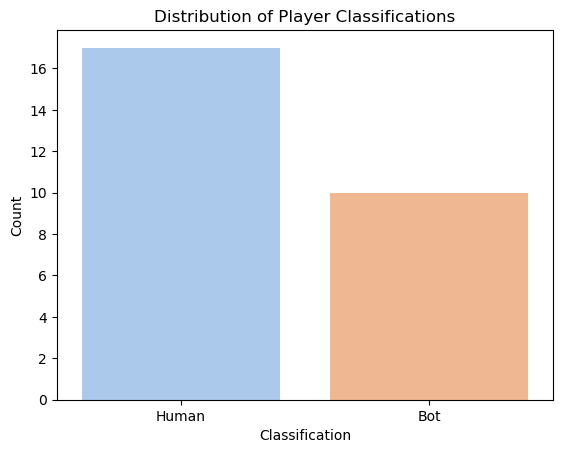

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x="Classification", palette="pastel")
plt.title("Distribution of Player Classifications")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.show()


/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/3226281667.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Classification", y="Confidence", palette="coolwarm")


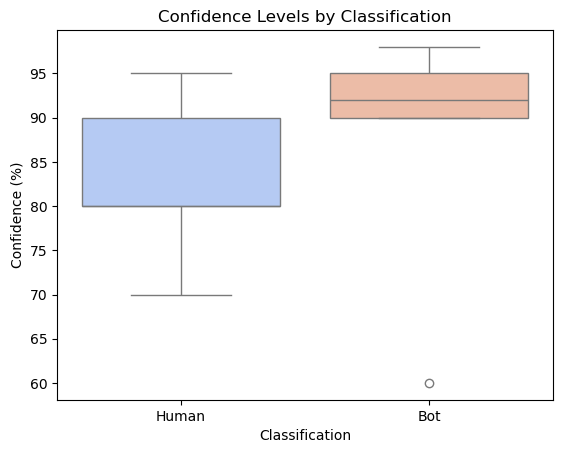

In [20]:
sns.boxplot(data=df, x="Classification", y="Confidence", palette="coolwarm")
plt.title("Confidence Levels by Classification")
plt.xlabel("Classification")
plt.ylabel("Confidence (%)")
plt.show()


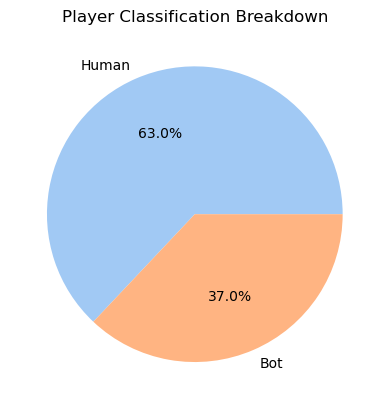

In [21]:
df['Classification'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("pastel"), 
                                             title="Player Classification Breakdown")
plt.ylabel("")
plt.show()


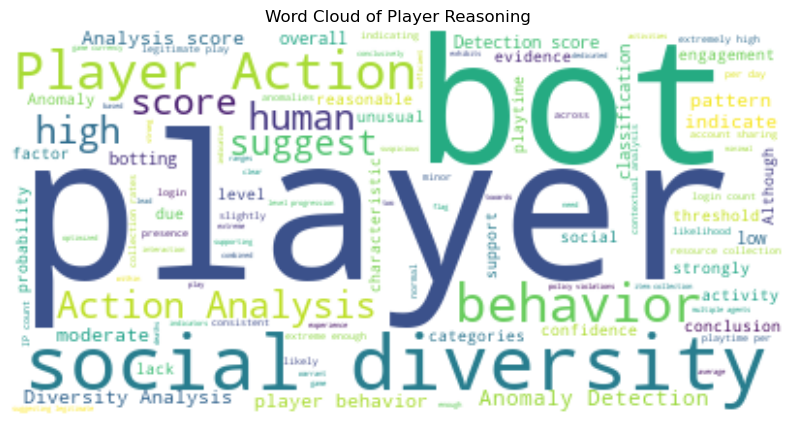

In [22]:
from wordcloud import WordCloud

text = " ".join(df['Reasoning'].dropna())
wordcloud = WordCloud(background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Player Reasoning")
plt.show()


/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/1989848276.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Classification", y="Confidence", palette="muted", inner="quartile")


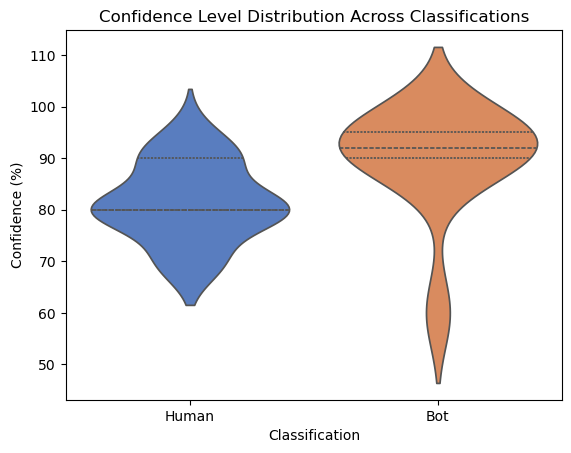

In [23]:
sns.violinplot(data=df, x="Classification", y="Confidence", palette="muted", inner="quartile")
plt.title("Confidence Level Distribution Across Classifications")
plt.xlabel("Classification")
plt.ylabel("Confidence (%)")
plt.show()


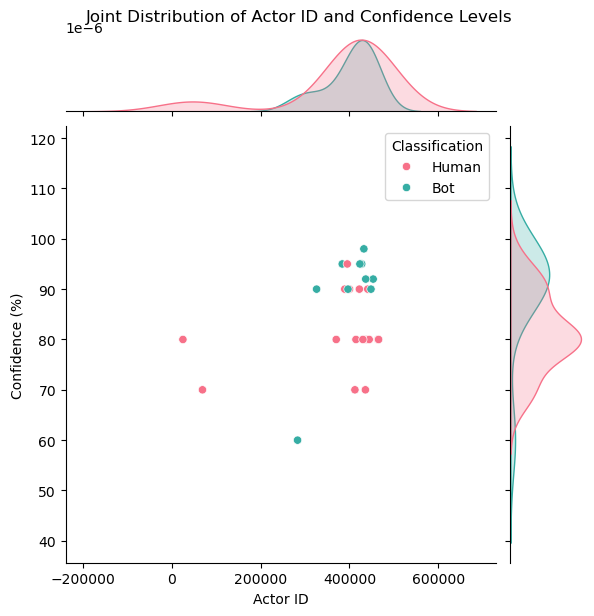

In [25]:
sns.jointplot(data=df, x="Actor", y="Confidence", hue="Classification", kind="scatter", palette="husl")
plt.suptitle("Joint Distribution of Actor ID and Confidence Levels", y=1.02)
plt.xlabel("Actor ID")
plt.ylabel("Confidence (%)")
plt.show()


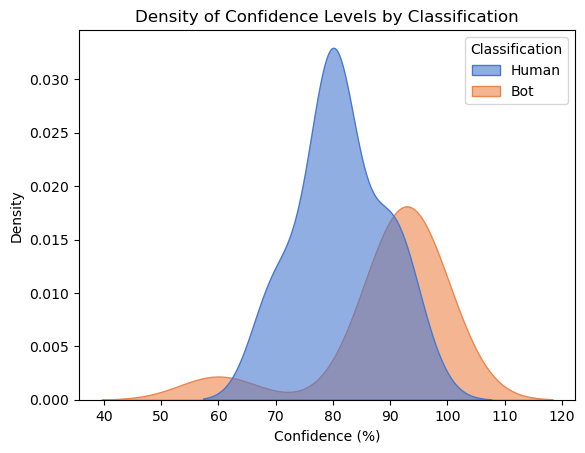

In [30]:
sns.kdeplot(data=df, x="Confidence", hue="Classification", fill=True, palette="muted", alpha=0.6)
plt.title("Density of Confidence Levels by Classification")
plt.xlabel("Confidence (%)")
plt.ylabel("Density")
plt.show()


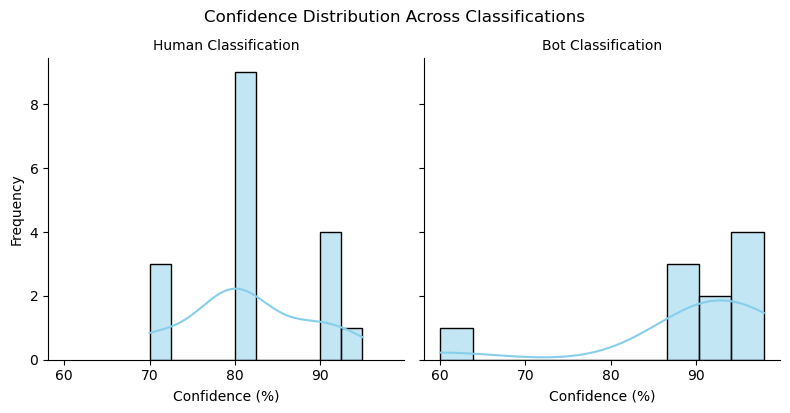

In [31]:
facet = sns.FacetGrid(df, col="Classification", height=4, aspect=1)
facet.map(sns.histplot, "Confidence", bins=10, kde=True, color="skyblue")
facet.set_titles("{col_name} Classification")
facet.set_axis_labels("Confidence (%)", "Frequency")
facet.fig.suptitle("Confidence Distribution Across Classifications", y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()


/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/3931531014.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Classification", y="Confidence", ci=None, palette="pastel")
/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/3931531014.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Classification", y="Confidence", ci=None, palette="pastel")


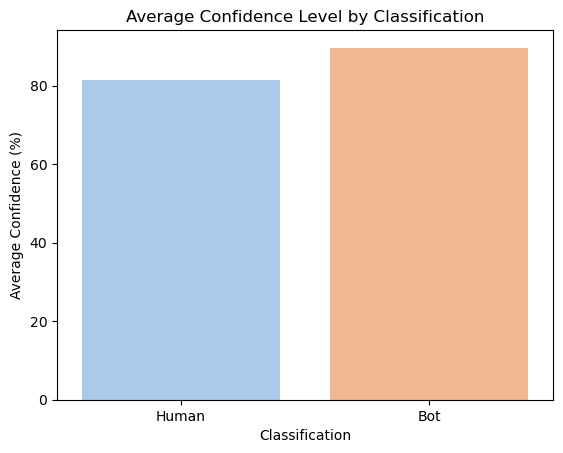

In [32]:
sns.barplot(data=df, x="Classification", y="Confidence", ci=None, palette="pastel")
plt.title("Average Confidence Level by Classification")
plt.xlabel("Classification")
plt.ylabel("Average Confidence (%)")
plt.show()


/var/folders/sy/4s0tvv155s961r1rz4db2sfw0000gn/T/ipykernel_65290/1224192197.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Classification", y="Confidence", jitter=True, palette="Set2", size=5)


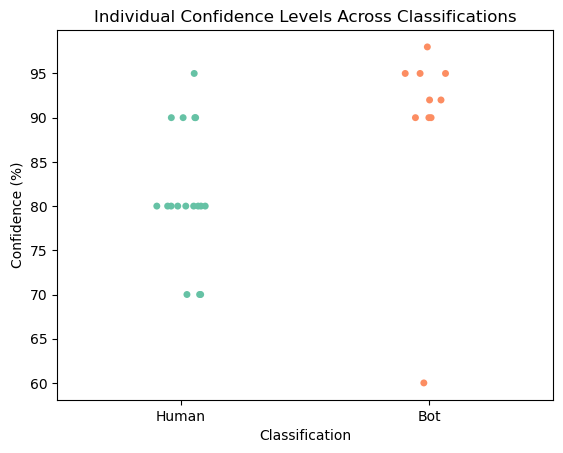

In [33]:
sns.stripplot(data=df, x="Classification", y="Confidence", jitter=True, palette="Set2", size=5)
plt.title("Individual Confidence Levels Across Classifications")
plt.xlabel("Classification")
plt.ylabel("Confidence (%)")
plt.show()


In [50]:
print(f"Context Recall: {metrics_cleaned['context_recall'].mean():.2f}")
print(f"Faithfulness: {metrics_cleaned['faithfulness'].mean():.2f}")
print(f"Factual Correctness: {metrics_cleaned['factual_correctness(mode=f1)'].mean():.2f}")

Context Recall: 0.87
Faithfulness: 0.95
Factual Correctness: 0.35


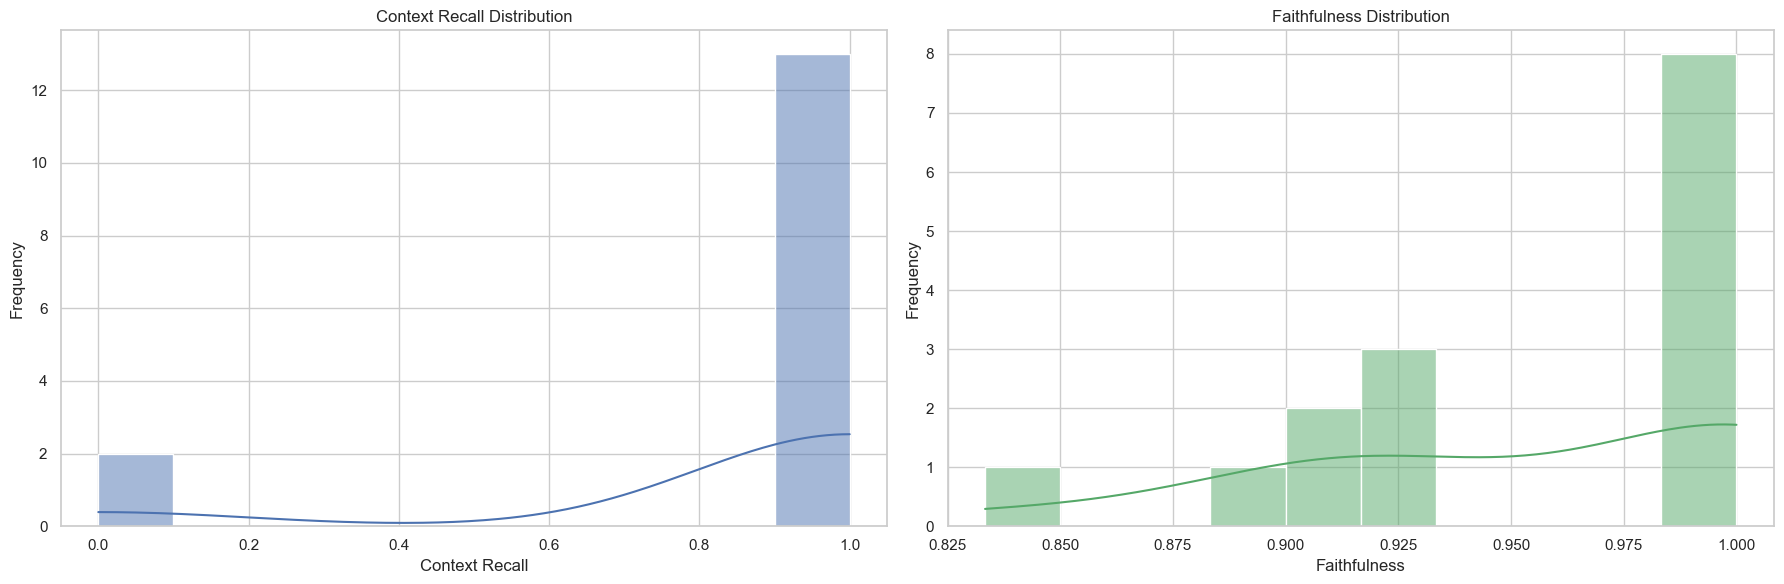

In [52]:
# print(f"Average Context Recall: {results['context_recall'].mean():.2f}")
# print(f"Average Faithfulness: {results['faithfulness'].mean():.2f}")
# print(f"Average Factual Correctness: {results['factual_correctness(mode=f1)'].mean():.2f}")
metrics_cleaned = results[['context_recall', 'faithfulness', 
                        'factual_correctness(mode=f1)', 'true_label']].dropna()

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. Distribution plots for each metric
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Context Recall
sns.histplot(metrics_cleaned['context_recall'], kde=True, 
             color="#4C72B0", bins=10, ax=axes[0])
axes[0].set_title("Context Recall Distribution")
axes[0].set_xlabel("Context Recall")
axes[0].set_ylabel("Frequency")

sns.histplot(metrics_cleaned['faithfulness'], kde=True, 
             color="#55A868", bins=10, ax=axes[1])
axes[1].set_title("Faithfulness Distribution")
axes[1].set_xlabel("Faithfulness")
axes[1].set_ylabel("Frequency")



plt.tight_layout()
plt.show()


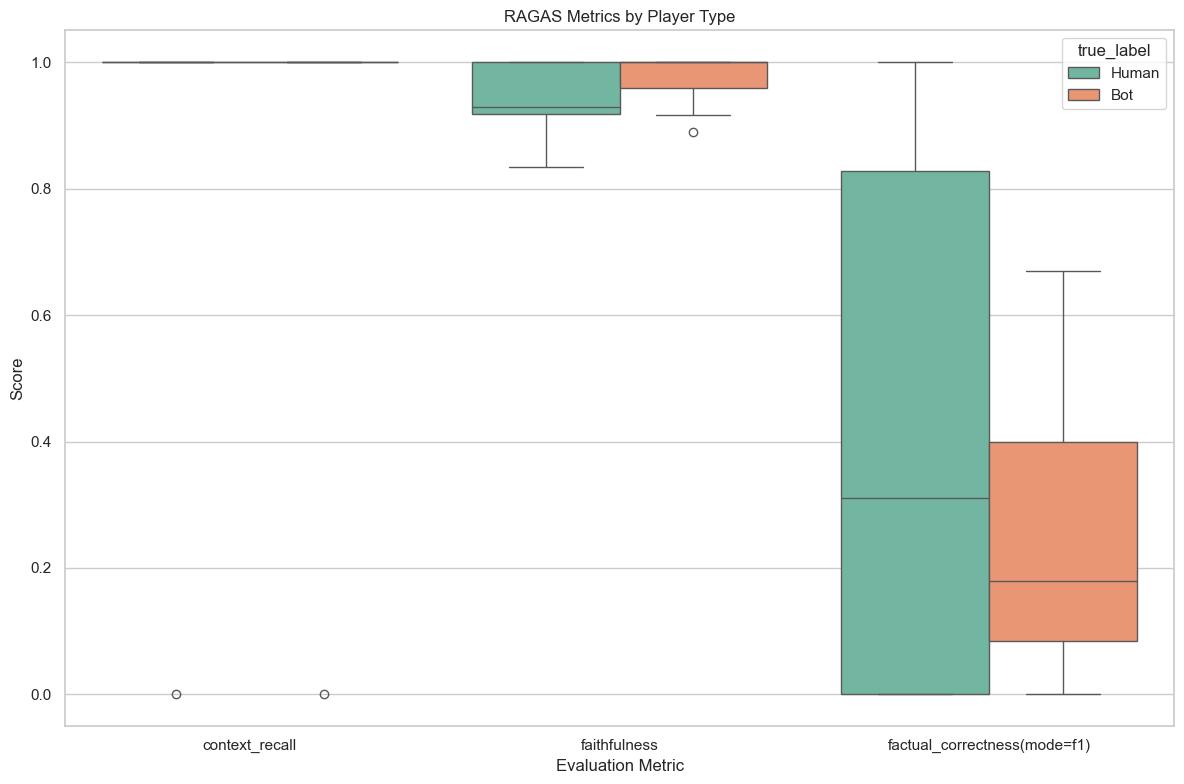

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

# Reshape data for boxplot
metrics_melted = pd.melt(metrics_cleaned, 
                         id_vars=['true_label'],
                         value_vars=['context_recall', 'faithfulness', 
                                     'factual_correctness(mode=f1)'],
                         var_name='Metric', value_name='Score')

# Create boxplot
sns.boxplot(x='Metric', y='Score', hue='true_label', 
            data=metrics_melted, palette='Set2', ax=ax)
ax.set_title('RAGAS Metrics by Player Type')
ax.set_xlabel('Evaluation Metric')
ax.set_ylabel('Score')
plt.tight_layout()
plt.show()


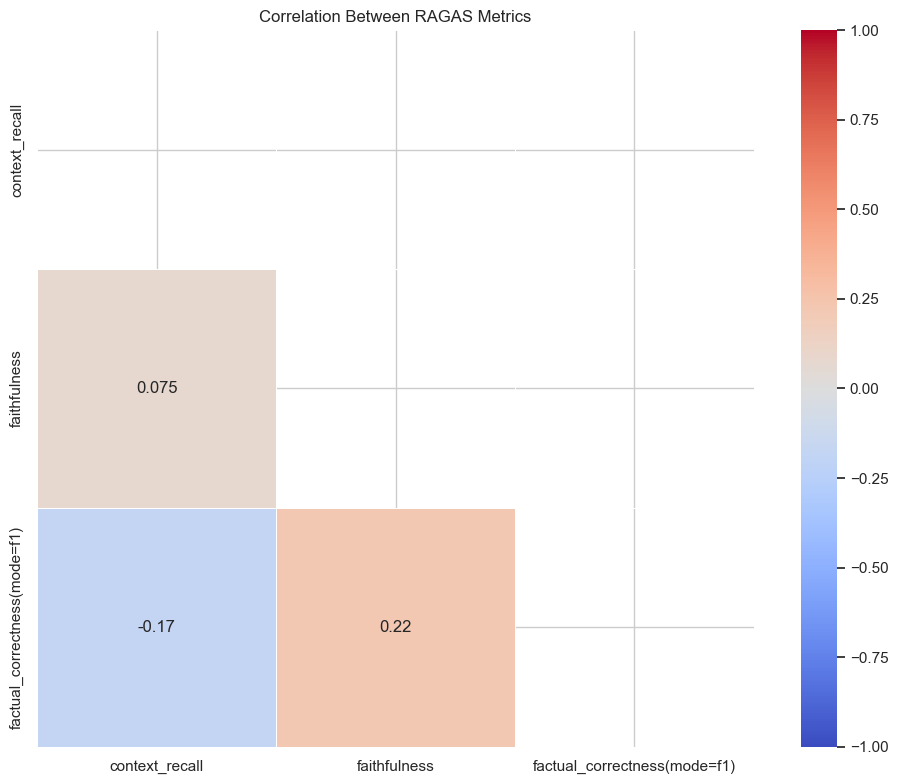

In [45]:
plt.figure(figsize=(10, 8))
corr = metrics_cleaned[['context_recall', 'faithfulness', 
                        'factual_correctness(mode=f1)']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            center=0, square=True, linewidths=.5)
plt.title('Correlation Between RAGAS Metrics')
plt.tight_layout()
plt.show()

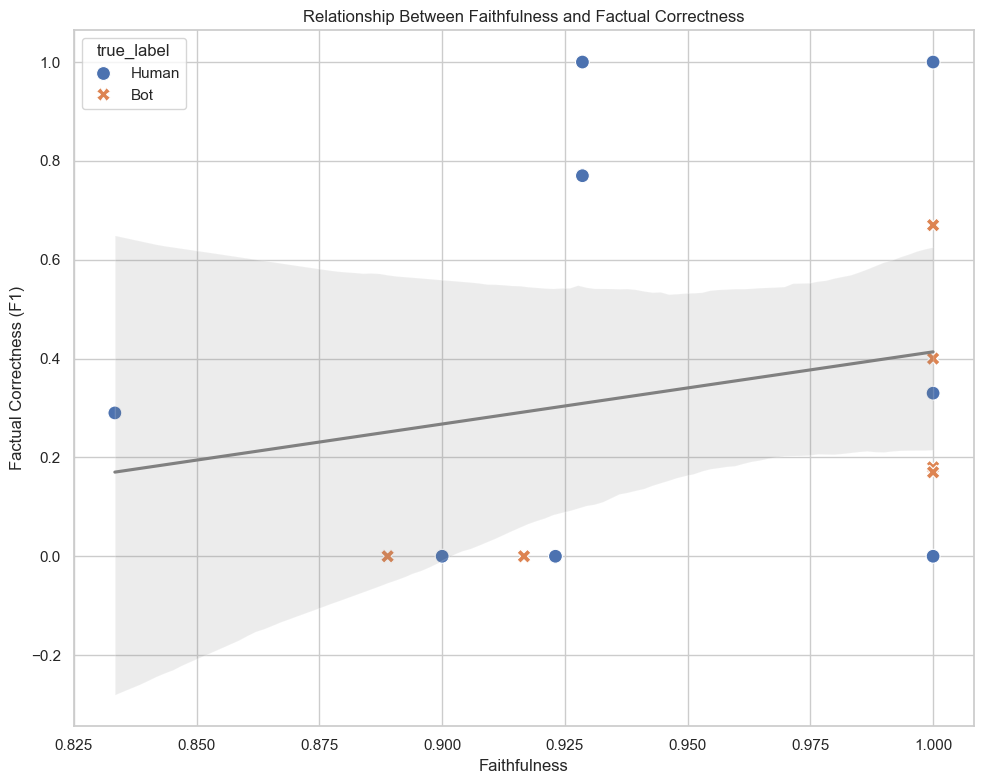

In [46]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=metrics_cleaned, x='faithfulness', 
                y='factual_correctness(mode=f1)', 
                hue='true_label', style='true_label', s=100)
sns.regplot(data=metrics_cleaned, x='faithfulness', 
            y='factual_correctness(mode=f1)', 
            scatter=False, line_kws={"color": "gray"})
plt.title('Relationship Between Faithfulness and Factual Correctness')
plt.xlabel('Faithfulness')
plt.ylabel('Factual Correctness (F1)')
plt.tight_layout()
plt.show()